## ConvLSTM Experiment


- For the ConvLSTM model, the current shortcoming is that it requires a full pCO2 data for the previous months. This aspect is particularly problematic as there exists no full pCO2 data.
    - The idea to address such an issue is to replace previous full pCO2 images with pCO2_socat so

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras

%matplotlib inline

import os
tf.random.set_seed(42)


sys.path.insert(0, '../../src')
from utils import df_to_xarray,read_xarray, get_point_prediction, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2022-05-22 20:32:50.567859: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def preprocess_images_nfp(dir_name,num="001",socat=False,mpi=False,can=False):
    
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num,mpi,can)
    
    if socat:

        chl_images = preprocess_image_reduced(chl.Chl_socat.data,socat=True)
        mld_images = preprocess_image_reduced(mld.MLD_socat.data,socat=True)
        sss_images = preprocess_image_reduced(sss.SSS_socat.data,socat=True)
        sst_images = preprocess_image_reduced(sst.SST_socat.data,socat=True)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2_socat.data,socat=True)
        X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images,pco2_images))
    else:
        chl_images = preprocess_image_reduced(chl.Chl.data)
        mld_images = preprocess_image_reduced(mld.MLD.data)
        sss_images = preprocess_image_reduced(sss.SSS.data)
        sst_images = preprocess_image_reduced(sst.SST.data)
        xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
        pco2_images = preprocess_image_reduced(pco2.pCO2.data)
        pco2_images_socat = preprocess_image_reduced(pco2.pCO2_socat.data)
        X = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images,pco2_images_socat))
    
    X = X.reshape((421,180,360,6),order='F')

    return X, pco2_images

In [14]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [33]:
tf.keras.backend.clear_session()

In [20]:
dir_name="../../data/data1"
val_dir_name="../../data/data2"

data,pco2 = preprocess_images_nfp(dir_name)
data_socat, pco2_socat = preprocess_images_nfp(dir_name, socat = True)

val_data,val_pco2 = preprocess_images_nfp(val_dir_name,"035")
val_data_socat,val_pco2_socat = preprocess_images_nfp(val_dir_name,"035",socat=True)

X_index=np.lib.stride_tricks.sliding_window_view(range(421),3) 

y=np.expand_dims(pco2[X_index][1:],axis=4)
X=data[X_index][:-1]

val_y=np.expand_dims(val_pco2[X_index][1:],axis=4)
val_X=val_data[X_index][:-1]


print(X.shape, y.shape)

INPUT_SHAPE = X[0].shape

(418, 3, 180, 360, 6) (418, 3, 180, 360, 1)


In [21]:
INPUT_SHAPE

(3, 180, 360, 6)

In [34]:
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(5,5)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(3,3)),
    #keras.layers.Dropout(0.1),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(1,1)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(learning_rate = 7e-4),
)
#larger than 0.001 (default) does not work very well

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 3, 180, 360, 32)   121728    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 3, 180, 360, 32)   204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 3, 180, 360, 32)   73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 3, 180, 360, 32)   8

In [ ]:
model_path="../../models/ConvLSTM_socat.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X,
    y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X,y),
    callbacks=callbacks,
)

Epoch 1/50
53/53 [==============================] - ETA: 0s - loss: 81.8395

In [ ]:
best_model = tf.keras.models.load_model('../../models/ConvLSTM_socat.h5', custom_objects={'custom_rmse':custom_rmse})
pred=best_model.predict(val_X,verbose=1)

In [ ]:
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(val_dir_name, num="035")

y_true,y_pred = inverse_scale_frame(pred,pco2t2.pCO2.data)


y_pred_socat = np.copy(y_pred)
y_true_socat=np.expand_dims(pco2t2.pCO2_socat.data[X_index][1:],axis=4)
y_true_socat = np.nan_to_num(y_true_socat)
y_pred_socat[y_true_socat==0]=0.0

In [ ]:
print("Full RMSE score:")
a=custom_rmse(y_pred[:,:1],y_true[:,:1])
print(a.numpy())

print("SOCAT RMSE score:")
b=custom_rmse(y_pred_socat[:,:1],y_true_socat[:,:1])
print(b.numpy())


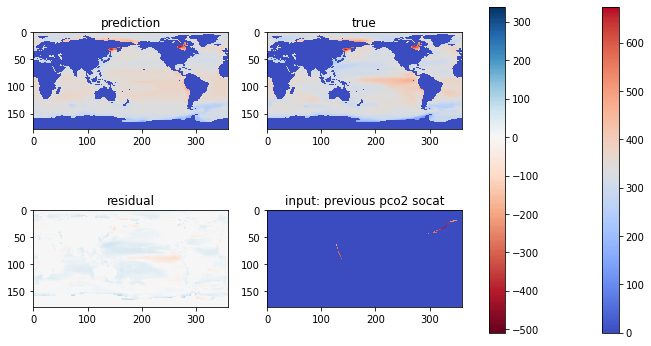

In [29]:
import imageio
import matplotlib.colors as mcolors

figure, axis = plt.subplots(2, 2,figsize=(12, 6))

d = y_pred - y_true


norm = mcolors.TwoSlopeNorm(vmin=d.min(), vmax = d.max(), vcenter=0)


img=axis[0][0].imshow(np.flipud(y_pred[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[0][1].imshow(np.flipud(y_true[0][1]),cmap="coolwarm", interpolation="nearest")
axis[0][1].set_title("true")

diff=np.flipud(np.squeeze(y_pred[0][1]-y_true[0][1]))
img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
axis[1][0].set_title("residual")
plt.colorbar(img2,ax=axis)


img2=axis[1][1].imshow(np.flipud(X[0][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
axis[1][1].set_title("input: previous pco2 socat")

plt.savefig('../../assets/next-frame-prediction-exp.png')

plt.show()

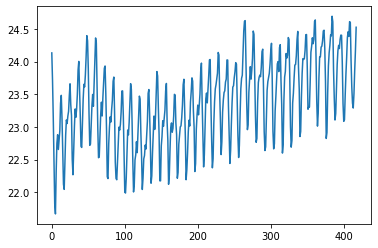

In [31]:
rmses = []

for i in range(418):    
    rmse = np.sqrt(np.mean((pred[i][1]-y[i][1])**2))
    rmses.append(rmse)
    
plt.plot(rmses)

plt.savefig('../../assets/nfp-overtime-exp.png')

In [32]:
#create gif

filenames = []

for i in range(418):
    # plot the line chart
    figure, axis = plt.subplots(2, 2,figsize=(12, 6))

    img=axis[0][0].imshow(np.flipud(y_pred[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][0].set_title("prediction")
    plt.colorbar(img,ax=axis)

    img1=axis[0][1].imshow(np.flipud(y_true[i][1]),cmap="coolwarm", interpolation="nearest")
    axis[0][1].set_title("true")

    diff=np.flipud(np.squeeze(y_pred[i][1]-y_true[i][1]))
    img2=axis[1][0].imshow(diff,cmap="RdBu", interpolation="nearest",norm=norm)
    axis[1][0].set_title("residual")
    plt.colorbar(img2,ax=axis)
    
    img2=axis[1][1].imshow(np.flipud(X[i][1][:,:,5]),cmap="coolwarm", interpolation="nearest")
    axis[1][1].set_title("input: previous pco2 socat")
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()


with imageio.get_writer('../../assets/cnn-lstm-exp.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)